## Setup

### Import Libraries

In [1]:
import os
import sys
import gc
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

### Import modules

In [ ]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Load configuration
from src.config import get_config
config = get_config()

print("✓ Configuration loaded successfully")
print(f"  Data root: {config.paths['data_root']}")
print(f"  Input directory: {config.paths['input']}")
print(f"  Processed directory: {config.paths['processed']}")

In [3]:
# Import modules
from src.data.loader import ThermalDataLoader
from src.features.thermal import create_thermal_threshold_tensor
from src.features.edge_detection import create_edge_detection_tensors
from src.data.preprocessor import prepare_labels
from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    visualize_feature_composition,
    get_label_examples
)

### Set CUDA

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Functions

In [5]:
def preprocess_dataset(dataset, thresholds=None):
    """
    Process any dataset by converting to tensors, creating features, and organizing data.
    
    Args:
        dataset: Dictionary containing the raw dataset with 'tensors', 'metadata', etc.
        
    Returns:
        dict: Preprocessed dataset with organized tensors, metadata, and labels
    """
    if dataset is None:
        raise ValueError("Dataset cannot be None")
    
    print("Starting dataset preprocessing...")
    
    # Convert numpy arrays to PyTorch tensors and check for NaN
    print("\nConverting tensors...")
    corrected_tensor = torch.tensor(dataset['tensors']['corrected']).float()
    
    # Check for NaN values in corrected tensor
    if torch.isnan(corrected_tensor).any():
        print("Warning: NaN values found in corrected tensor!")
        print(f"Number of NaN values: {torch.isnan(corrected_tensor).sum().item()}")
        # Replace NaN with 0
        corrected_tensor = torch.nan_to_num(corrected_tensor, nan=0.0)
    
    # Create all initial tensors
    print("\nCreating feature tensors...")
    
    # Create edge detection tensors
    print("- Creating edge detection tensors...")
    edge_detection_data = create_edge_detection_tensors(corrected_tensor)
    edge_tensor = torch.tensor(edge_detection_data['edge_tensor']).float()
    edge_features = torch.tensor(edge_detection_data['edge_features']).float()
    
    # Check edge tensors for NaN
    if torch.isnan(edge_tensor).any():
        print("Warning: NaN values found in edge tensor!")
        edge_tensor = torch.nan_to_num(edge_tensor, nan=0.0)
    
    if torch.isnan(edge_features).any():
        print("Warning: NaN values found in edge features!")
        edge_features = torch.nan_to_num(edge_features, nan=0.0)
    
    # Create threshold tensors
    print("- Creating threshold tensors...")
    threshold_data = create_thermal_threshold_tensor(corrected_tensor, thresholds=thresholds)
    
    # Check threshold tensors for NaN
    for name, tensor in threshold_data['tensors'].items():
        if torch.isnan(tensor).any():
            print(f"Warning: NaN values found in threshold tensor {name}!")
            threshold_data['tensors'][name] = torch.nan_to_num(tensor, nan=0.0)
    
    # Prepare labels
    print("\nPreparing labels...")
    labels_data = prepare_labels(dataset)
    
    # Create preprocessed dataset dictionary
    print("\nOrganizing preprocessed dataset...")
    preprocessed_dataset = {
        'tensors': {
            'corrected': corrected_tensor,  
            'edge': edge_tensor,
            'edge_features': edge_features,
            'threshold': threshold_data['tensors']
        },
        'metadata': dataset['metadata'],
        'labels': {
            'numeric_labels': labels_data['numeric_labels'],
            'label_mapping': labels_data['label_mapping']
        }
    }
    
    # Print shapes of processed tensors
    print("\nProcessed tensor shapes:")
    print(f"Corrected: {preprocessed_dataset['tensors']['corrected'].shape}")
    print(f"Edge: {preprocessed_dataset['tensors']['edge'].shape}")
    print(f"Edge features: {preprocessed_dataset['tensors']['edge_features'].shape}")
    print("Threshold tensors:")
    for name, tensor in preprocessed_dataset['tensors']['threshold'].items():
        print(f"- {name}: {tensor.shape}")
    print(f"Labels: {preprocessed_dataset['labels']['numeric_labels'].shape}")
    
    print("\nDataset preprocessing completed!")
    return preprocessed_dataset

In [6]:
def extract_visualization_data(preprocessed_dataset):
    """
    Extract necessary data from preprocessed dataset for visualization.
    
    Args:
        preprocessed_dataset: Output from preprocess_dataset() function
        
    Returns:
        dict: Dictionary containing all data needed for visualization
    """
    return {
        'timestamps': preprocessed_dataset['metadata']['timestamps'],
        'numeric_labels': preprocessed_dataset['labels']['numeric_labels'],
        'label_mapping': preprocessed_dataset['labels']['label_mapping'],
        'corrected_tensor': preprocessed_dataset['tensors']['corrected']
    }

In [7]:
def resize_tensor(tensor, target_height, target_width, mode='bilinear'):
    """
    Resize a 3D tensor (H, W, T) to (target_height, target_width, T).
    Use mode='nearest' for binary/mask tensors, 'bilinear' for continuous.
    """
    tensor = tensor.permute(2, 0, 1).unsqueeze(1)  # (T, 1, H, W)
    tensor_resized = F.interpolate(
        tensor, size=(target_height, target_width), mode=mode, align_corners=False if mode=='bilinear' else None
    )
    tensor_resized = tensor_resized.squeeze(1).permute(1, 2, 0)  # (H, W, T)
    return tensor_resized

def resize_preprocessed_dataset(preprocessed_dataset, target_height, target_width):
    """
    Resize all spatial tensors in a preprocessed dataset to the target size.
    """
    # Resize corrected tensor
    corrected = preprocessed_dataset['tensors']['corrected']
    preprocessed_dataset['tensors']['corrected'] = resize_tensor(corrected, target_height, target_width, mode='bilinear')

    # Resize edge tensor
    edge = preprocessed_dataset['tensors']['edge']
    preprocessed_dataset['tensors']['edge'] = resize_tensor(edge, target_height, target_width, mode='bilinear')

    # Resize threshold tensors (use nearest for binary masks)
    for name, tensor in preprocessed_dataset['tensors']['threshold'].items():
        preprocessed_dataset['tensors']['threshold'][name] = resize_tensor(tensor, target_height, target_width, mode='nearest')

    return preprocessed_dataset

In [8]:
def save_preprocessed_dataset(preprocessed_dataset, filename='preprocessed_dataset.pt'):
    """
    Save the preprocessed dataset to the processed directory and print tensor shapes.
    
    Args:
        preprocessed_dataset (dict): The dataset to save.
        filename (str): Name of the file to save.
    """
    # Get project root path (up one level from notebooks)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    
    # Create processed directory in the correct location
    processed_dir = os.path.join(project_root, 'data', 'processed')
    os.makedirs(processed_dir, exist_ok=True)
    
    # Save the preprocessed dataset
    print("\nSaving preprocessed dataset...")
    preprocessed_dataset_path = os.path.join(processed_dir, filename)
    torch.save(preprocessed_dataset, preprocessed_dataset_path)
    print("Dataset saved successfully!")

    # Print shapes of saved tensors
    print("\nTensor shapes:")
    print(f"Corrected: {preprocessed_dataset['tensors']['corrected'].shape}")
    print(f"Edge: {preprocessed_dataset['tensors']['edge'].shape}")
    print("Threshold tensors:")
    for name, tensor in preprocessed_dataset['tensors']['threshold'].items():
        print(f"- {name}: {tensor.shape}")
    print(f"Labels: {preprocessed_dataset['labels']['numeric_labels'].shape}")

## Cotopaxi Tensors

### Data Loader

In [ ]:
# Get allowed labels from configuration
allowed_labels = set(config.data['allowed_labels'])
print(f"Allowed labels: {allowed_labels}")

In [ ]:
# Create absolute paths using configuration
base_directories_COTOPAXI = [
    os.path.join(project_root, config.paths['input'], 'Cotopaxi/Nublado'),
    os.path.join(project_root, config.paths['input'], 'Cotopaxi/Emisiones'),
    os.path.join(project_root, config.paths['input'], 'Cotopaxi/Despejado')
]

# Initialize data loader with config settings
print("\nInitializing data loader...")
thermal_loader_cotopaxi = ThermalDataLoader(
    base_directories=base_directories_COTOPAXI,
    limit_per_directory=config.data['limit_per_directory'],  # None for all files
    allowed_labels=allowed_labels
)

### Create dataset

In [11]:
# Create initial dataset
print("\nCreating Cotopaxi dataset...")
dataset_cotopaxi = thermal_loader_cotopaxi.create_dataset()


Creating Cotopaxi dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Cotopaxi\Nublado


Processing files in Nublado: 100%|██████████| 401/401 [00:07<00:00, 55.28it/s]



Successfully processed 401 files from Nublado

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Cotopaxi\Emisiones


Processing files in Emisiones:  40%|████      | 1414/3498 [00:24<00:31, 66.14it/s]

Skipping c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Cotopaxi\Emisiones\CTP_RUMHIR_20221206_0448.fff: All NaN values after correction


Processing files in Emisiones:  68%|██████▊   | 2381/3498 [00:39<00:18, 61.27it/s]

Skipping c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Cotopaxi\Emisiones\CTP_RUMHIR_20221221_0039.fff: All NaN values after correction


Processing files in Emisiones: 100%|██████████| 3498/3498 [00:57<00:00, 60.59it/s]



Problematic files summary:
  CTP_RUMHIR_20221206_0448.fff: Invalid or NaN image - skipped
  CTP_RUMHIR_20221221_0039.fff: Invalid or NaN image - skipped

Total skipped files: 2

Successfully processed 3496 files from Emisiones

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Cotopaxi\Despejado


Processing files in Despejado: 100%|██████████| 3127/3127 [00:51<00:00, 60.16it/s]



Successfully processed 3127 files from Despejado

Finalizing dataset...

Creating tensors for 7024 images...
Image dimensions: 480x640
Estimated memory requirement: 16.08 GB

Allocating memory...

Processing batch 1/15

Processing batch 2/15

Processing batch 3/15

Processing batch 4/15

Processing batch 5/15

Processing batch 6/15

Processing batch 7/15

Processing batch 8/15

Processing batch 9/15

Processing batch 10/15

Processing batch 11/15

Processing batch 12/15

Processing batch 13/15

Processing batch 14/15

Processing batch 15/15


In [ ]:
# Get Cotopaxi thresholds from configuration
cotopaxi_thresholds = config.thresholds['cotopaxi']
print(f"Cotopaxi thresholds: {cotopaxi_thresholds}")

In [ ]:
preprocessed_cotopaxi = preprocess_dataset(dataset_cotopaxi, thresholds=cotopaxi_thresholds)

Starting dataset preprocessing...

Converting tensors...

Creating feature tensors...
- Creating edge detection tensors...
- Creating threshold tensors...

Preparing labels...

Organizing preprocessed dataset...

Processed tensor shapes:
Corrected: torch.Size([480, 640, 7024])
Edge: torch.Size([480, 640, 7024])
Edge features: torch.Size([7024, 3])
Threshold tensors:
- low: torch.Size([480, 640, 7024])
- medium: torch.Size([480, 640, 7024])
- high: torch.Size([480, 640, 7024])
- very_high: torch.Size([480, 640, 7024])
Labels: torch.Size([7024])

Dataset preprocessing completed!


In [ ]:
# Resize tensors to target dimensions from config
target_height = config.image['target_height']
target_width = config.image['target_width']
print(f"Resizing to: {target_height}x{target_width}")
preprocessed_cotopaxi = resize_preprocessed_dataset(preprocessed_cotopaxi, target_height, target_width)

In [14]:
save_preprocessed_dataset(preprocessed_cotopaxi, filename='cotopaxi_preprocessed.pt')


Saving preprocessed dataset...
Dataset saved successfully!

Tensor shapes:
Corrected: torch.Size([240, 320, 7024])
Edge: torch.Size([240, 320, 7024])
Threshold tensors:
- low: torch.Size([240, 320, 7024])
- medium: torch.Size([240, 320, 7024])
- high: torch.Size([240, 320, 7024])
- very_high: torch.Size([240, 320, 7024])
Labels: torch.Size([7024])


### Data Visualization

In [10]:
# Load saved preprocessed dataset
preprocessed_cotopaxi_path = os.path.join(project_root, 'data', 'processed', 'cotopaxi_preprocessed.pt')
preprocessed_cotopaxi = torch.load(preprocessed_cotopaxi_path, map_location=device)
print(f"Loaded preprocessed Cotopaxi dataset from {preprocessed_cotopaxi_path}")

C:\Users\Francisco\AppData\Local\Temp\ipykernel_10688\3056306707.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preprocessed_cotopaxi = torch.load(preprocessed_cotopaxi

Loaded preprocessed Cotopaxi dataset from c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\processed\cotopaxi_preprocessed.pt


#### Thermal Sequence

In [11]:
# Reload modules to get updated visualization functions
import importlib
import src.utils.visualization
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    visualize_feature_composition,
    get_label_examples
)

Temperature Statistics:
Global min: -14.86°C
Global max: 23.68°C
Mean temperature: -1.61°C
Standard deviation: 6.25°C


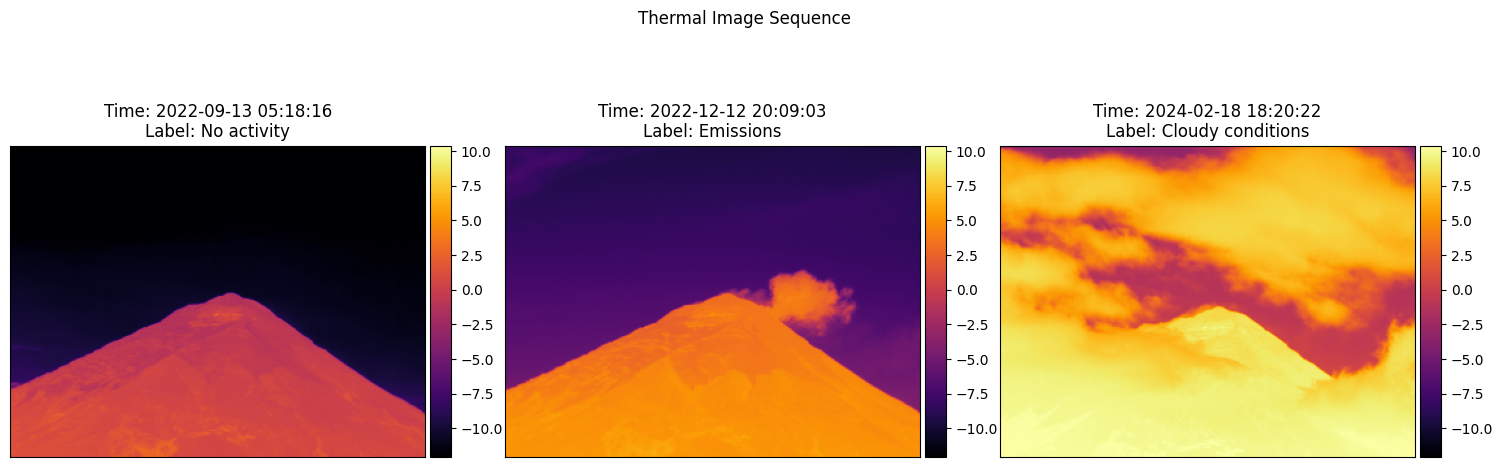

In [12]:
# Extract data for visualization
viz_data_cotopaxi = extract_visualization_data(preprocessed_cotopaxi)

# Use the extracted data
timestamps = viz_data_cotopaxi['timestamps']
numeric_labels = viz_data_cotopaxi['numeric_labels']
label_mapping = viz_data_cotopaxi['label_mapping']
corrected_tensor = viz_data_cotopaxi['corrected_tensor']

label_examples = get_label_examples(numeric_labels, label_mapping)
#example_indices = list(label_examples.values())
example_indices = [700, 3500, 6950]  # Replace with your desired indices

thermal_stats = get_thermal_stats(corrected_tensor)
print_thermal_stats(thermal_stats)

# Create English label mapping
label_mapping_english = {
    'No activity': label_mapping['Despejado'],
    'Emissions': label_mapping['Emisiones'],
    'Cloudy conditions': label_mapping['Nublado']
}

# Improved visualization with better contrast for Cotopaxi
visualize_thermal_sequence(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,
    thermal_stats['global_min'],
    thermal_stats['global_max'],
    label_mapping_english,
    use_percentile=True,  # Use percentile normalization for better contrast
    percentile_range=(2, 98),  # Focus on the 2-98 percentile range
    cmap='inferno'
)

#### Thresholds Sequence

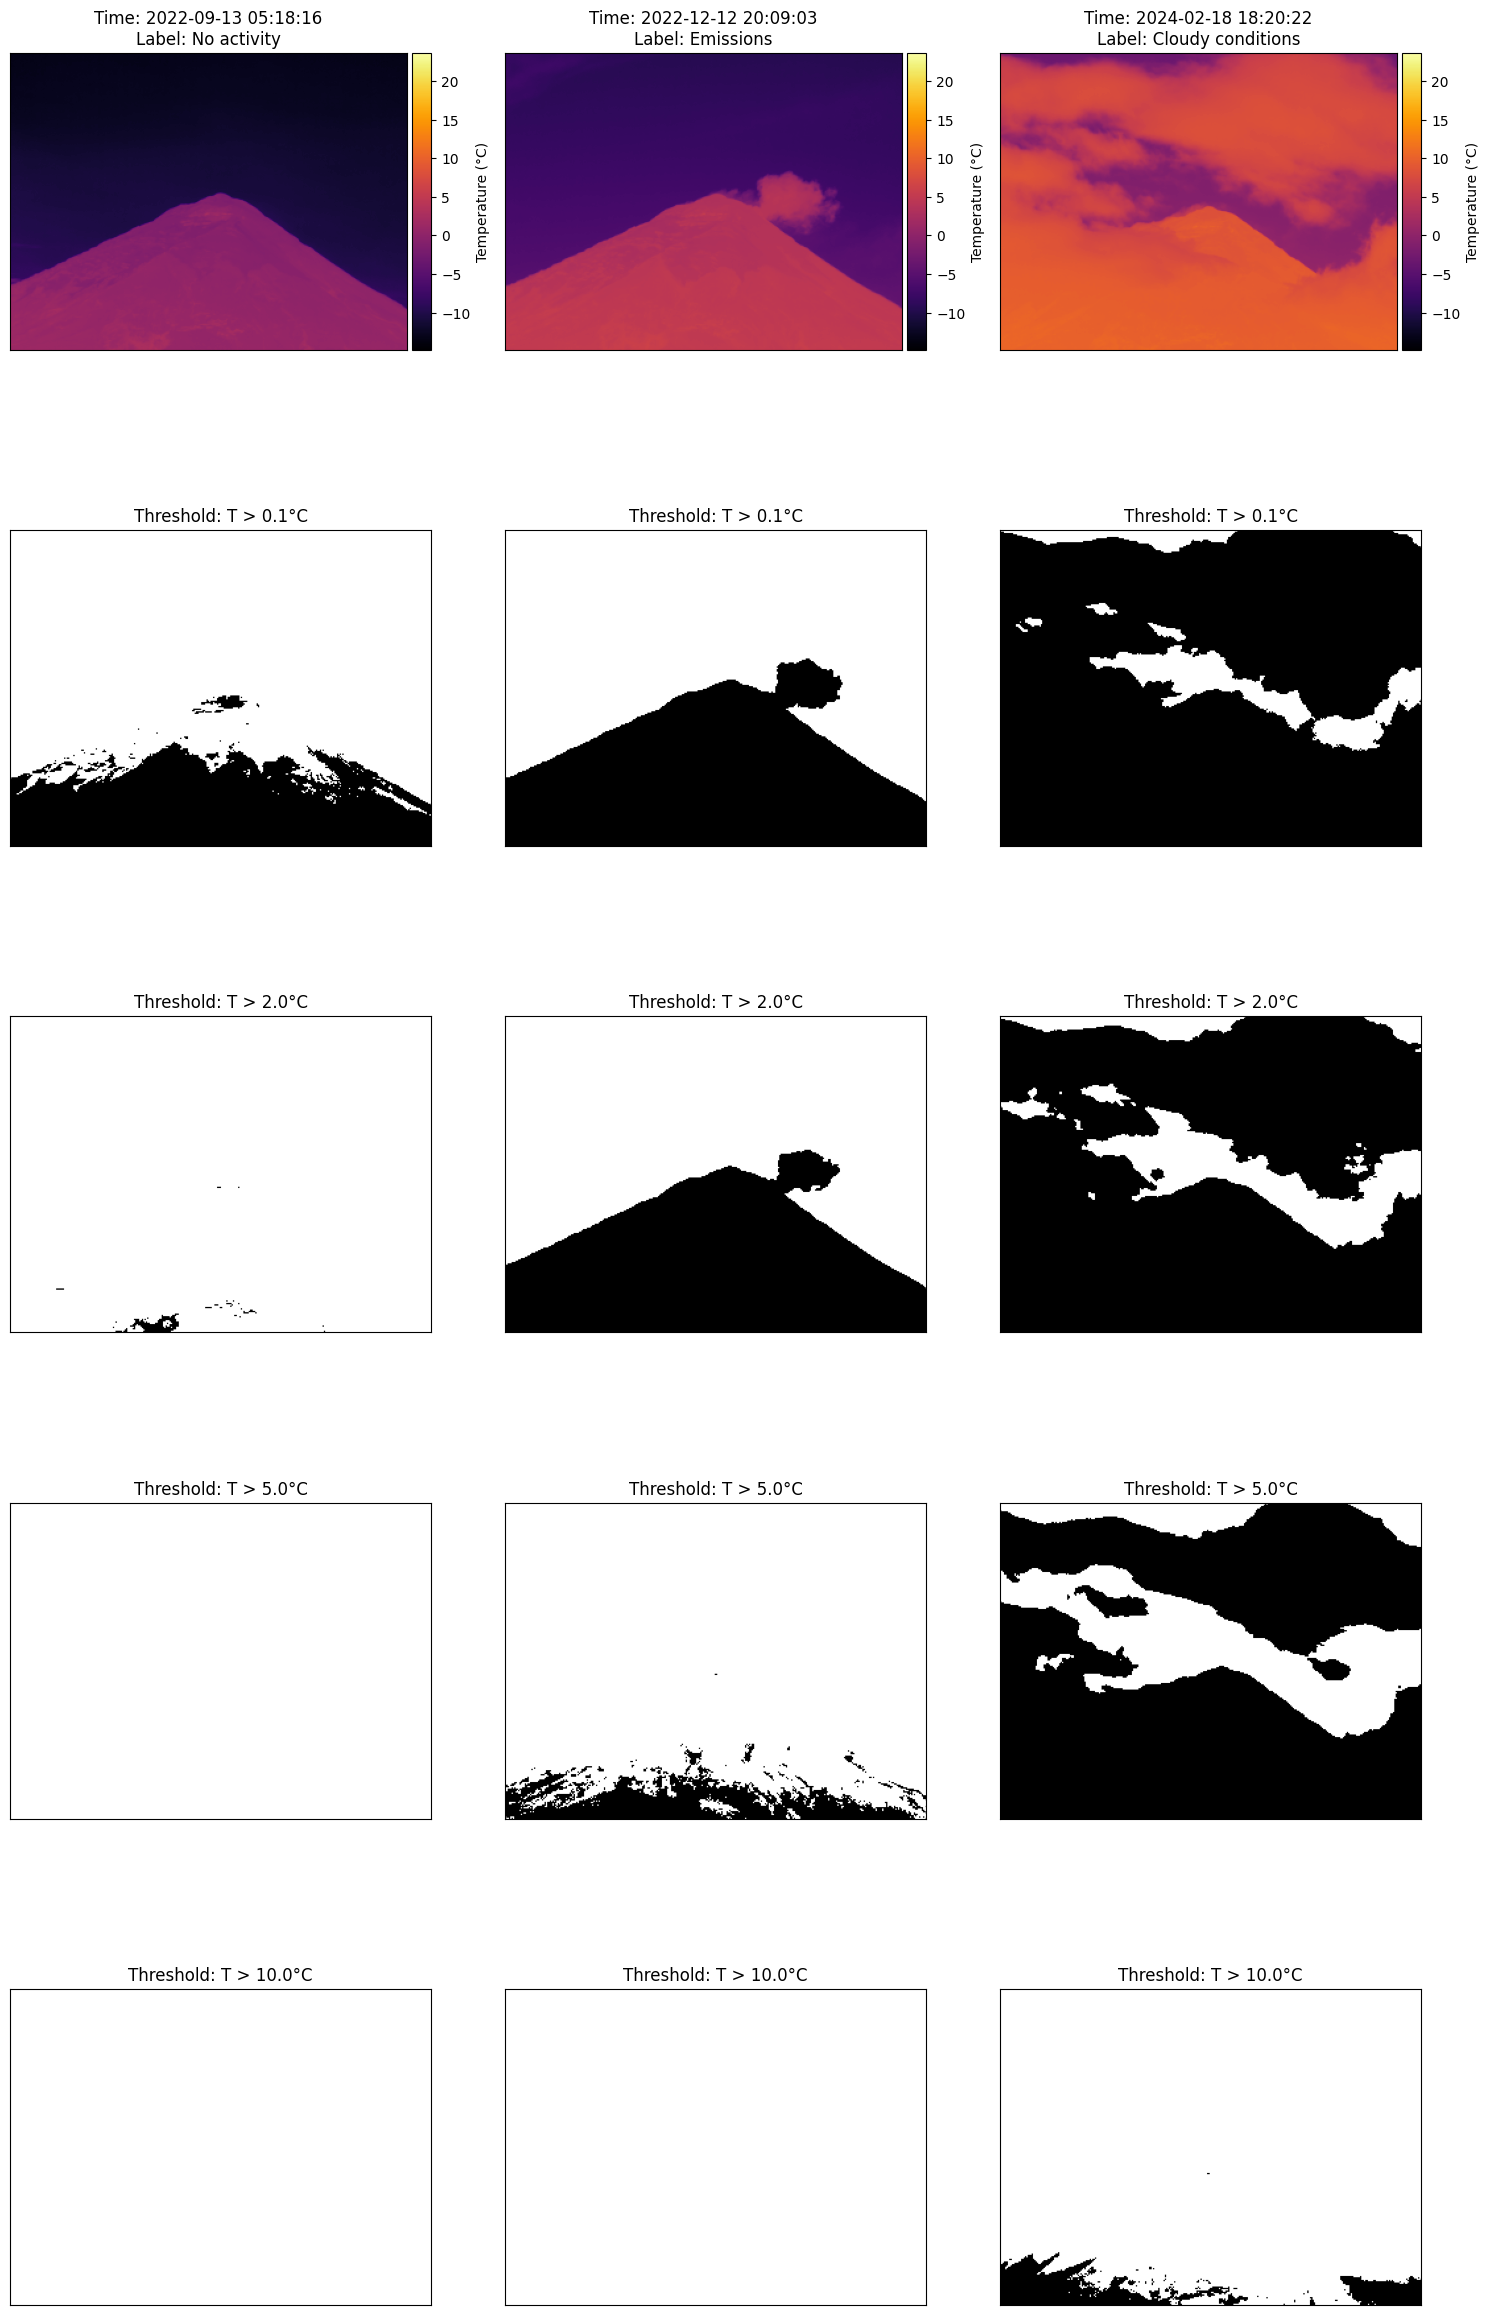

In [13]:
# Thermal threshold visualization
visualize_thermal_threshold_comparison(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices from before
    label_mapping_english,
    thresholds=cotopaxi_thresholds
)

#### Edges Sequence


Edge Detection Statistics:
Average edge density: 1.6807
Average total edges: 1.52
Average non-zero ratio: 1.5362


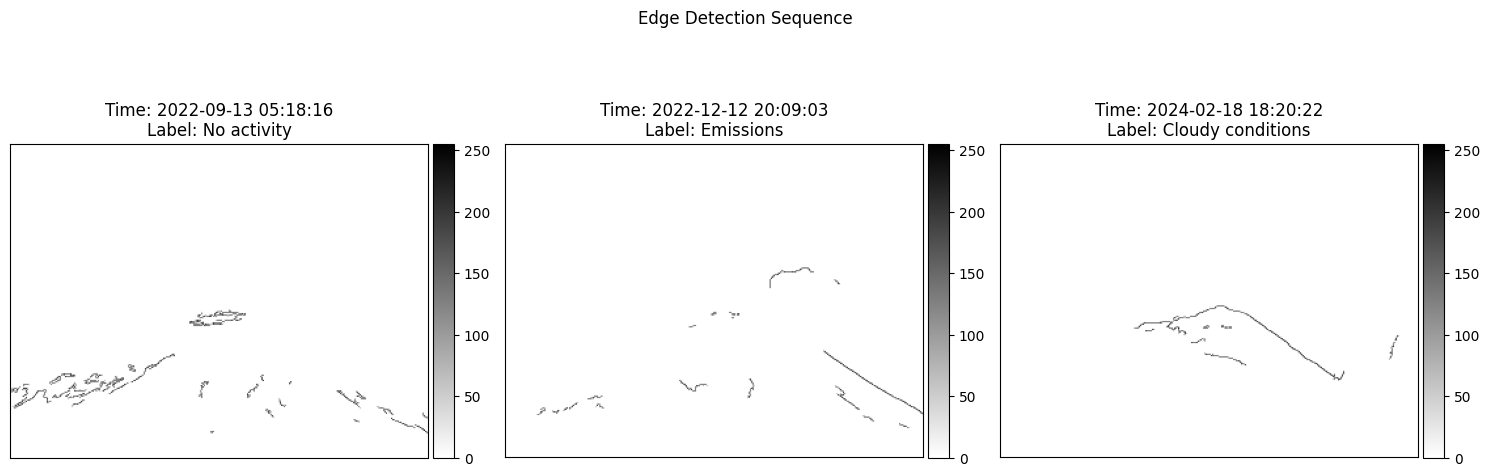

In [14]:
# Edge detection visualization and stats
edge_tensor = preprocessed_cotopaxi['tensors']['edge']
edge_stats = get_edge_stats(edge_tensor)
print_edge_stats(edge_stats)
visualize_edge_sequence(
    edge_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices we created before
    label_mapping_english
)

#### Feature Composition (Academic Paper)

c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\utils\visualization.py:334: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9 if show_colorbar else 1, 1], h_pad=0.5)


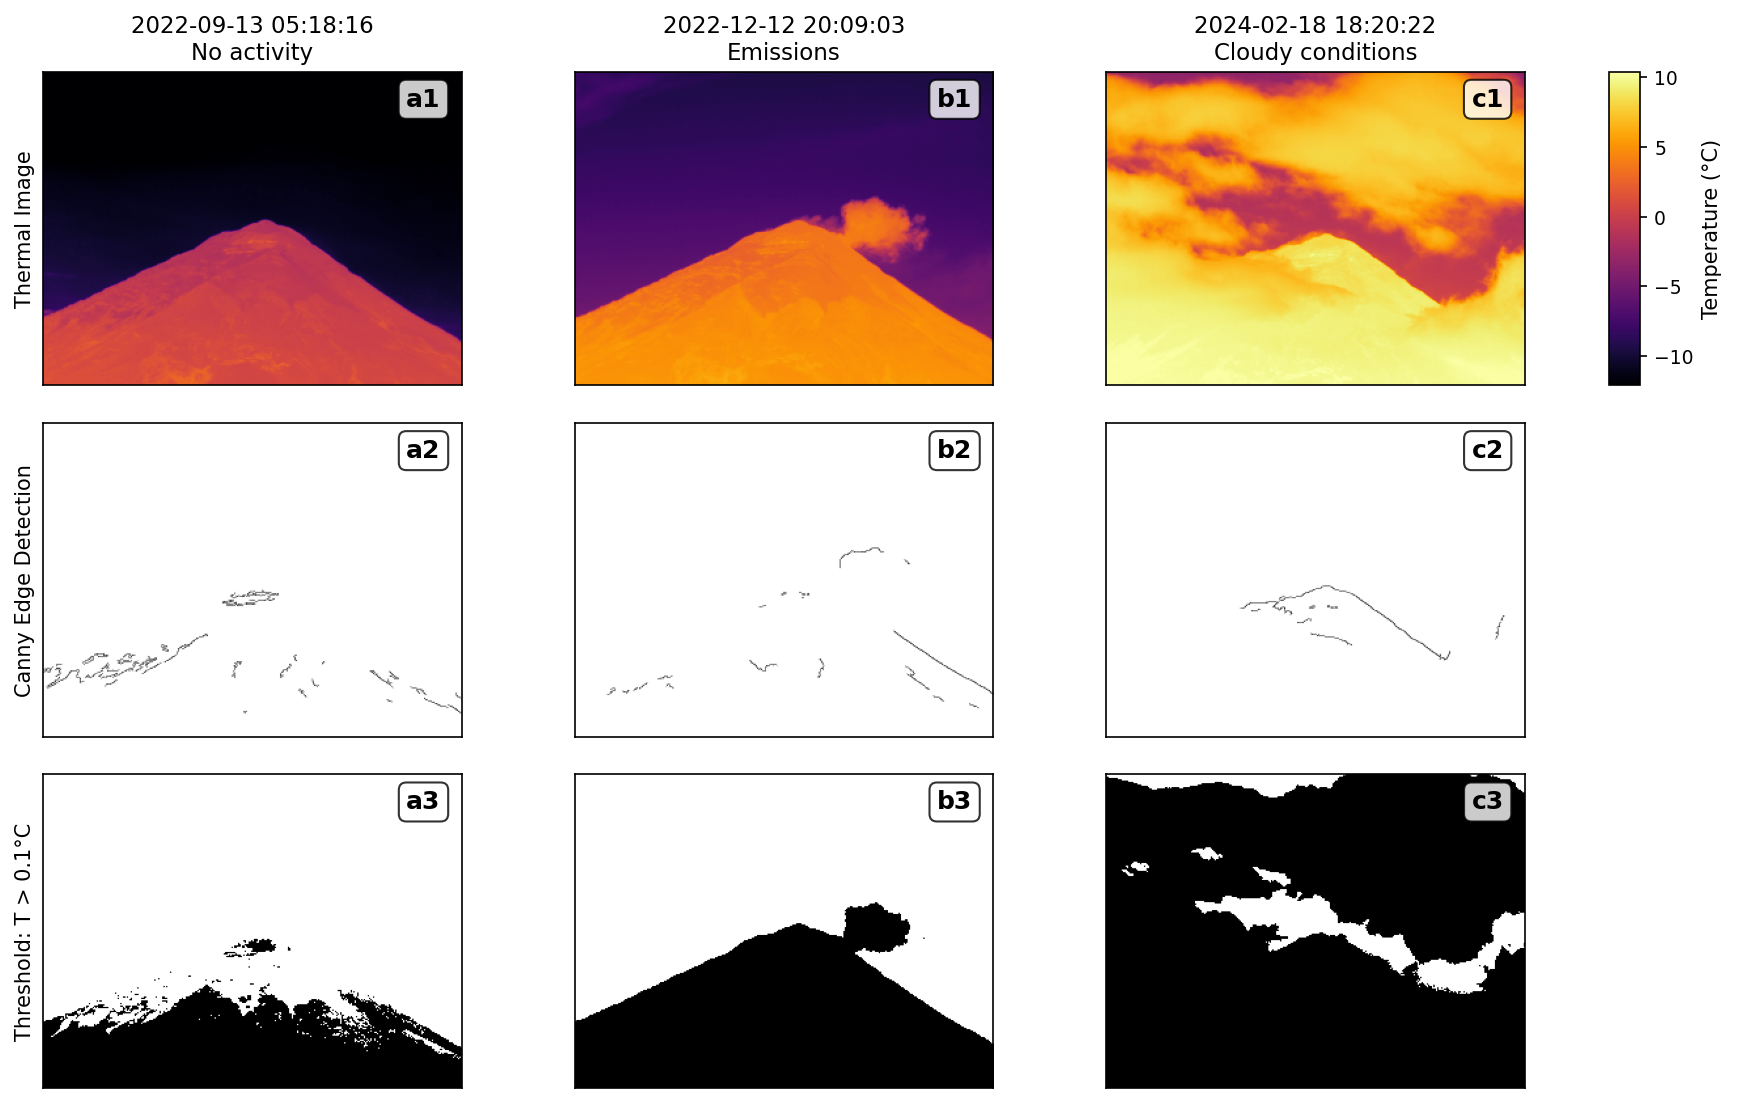

In [15]:
# Feature composition visualization for Cotopaxi (academic paper quality)
# Using the same example indices from previous visualizations

# Get threshold tensors from preprocessed dataset
threshold_tensors_cotopaxi = preprocessed_cotopaxi['tensors']['threshold']

# Create composition with thermal, edge detection, and threshold
# Using improved contrast with percentile normalization
fig_cotopaxi, axes_cotopaxi = visualize_feature_composition(
    thermal_tensor=corrected_tensor,
    edge_tensor=edge_tensor,
    threshold_tensors=threshold_tensors_cotopaxi,
    timestamps=timestamps,
    labels=numeric_labels,
    indices=example_indices,
    label_mapping=label_mapping_english,
    threshold_name='low',
    threshold_value=cotopaxi_thresholds['low'],
    figsize_per_col=4,
    dpi=150,
    cmap_thermal='inferno',
    show_colorbar=True,
    title_fontsize=11,
    label_fontsize=10,
    use_percentile=True,  # Enable percentile normalization
    percentile_range=(2, 98),  # Use 2-98 percentile for better contrast
    #save_path=None  # Set path to save: e.g., '../figures/cotopaxi_composition.png'
)

In [16]:
# Delete your tensor variables
del corrected_tensor
del edge_tensor
del preprocessed_cotopaxi

# Run garbage collection
gc.collect()

# If using CUDA, clear the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Reventador Tensors

### Data Loader

In [ ]:
# Create paths for Reventador using configuration
base_directories_REVENTADOR = [
    os.path.join(project_root, config.paths['input'], 'Reventador/Nublado'),
    os.path.join(project_root, config.paths['input'], 'Reventador/Emisiones'),
    os.path.join(project_root, config.paths['input'], 'Reventador/Flujo')
]

# Initialize data loader
print("\nInitializing data loader...")
thermal_loader_reventador = ThermalDataLoader(
    base_directories=base_directories_REVENTADOR,
    limit_per_directory=config.data['limit_per_directory'],
    allowed_labels=allowed_labels
)

### Create dataset

In [12]:
# Create initial dataset
print("\nCreating Revemtador dataset...")
dataset_reventador = thermal_loader_reventador.create_dataset()


Creating Revemtador dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Reventador\Nublado


Processing files in Nublado:  30%|██▉       | 459/1548 [00:03<00:07, 145.47it/s]c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\src\data\loader.py:151: RuntimeWarning: invalid value encountered in log
  return B / np.log(R1 / (R2 * (raw_obj + O)) + F) - 273.15
Processing files in Nublado: 100%|██████████| 1548/1548 [00:11<00:00, 132.50it/s]



Successfully processed 1548 files from Nublado

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Reventador\Emisiones


Processing files in Emisiones: 100%|██████████| 789/789 [00:06<00:00, 130.69it/s]



Successfully processed 789 files from Emisiones

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Reventador\Flujo


Processing files in Flujo: 100%|██████████| 1199/1199 [00:09<00:00, 131.54it/s]



Successfully processed 1199 files from Flujo

Finalizing dataset...

Creating tensors for 3536 images...
Image dimensions: 240x320
Estimated memory requirement: 2.02 GB

Allocating memory...

Processing batch 1/8

Processing batch 2/8

Processing batch 3/8

Processing batch 4/8

Processing batch 5/8

Processing batch 6/8

Processing batch 7/8

Processing batch 8/8


In [ ]:
# Get Reventador thresholds from configuration
reventador_thresholds = config.thresholds['reventador']
print(f"Reventador thresholds: {reventador_thresholds}")

In [ ]:
preprocessed_reventador = preprocess_dataset(dataset_reventador, thresholds=reventador_thresholds)

Starting dataset preprocessing...

Converting tensors...
Number of NaN values: 54038

Creating feature tensors...
- Creating edge detection tensors...
- Creating threshold tensors...

Preparing labels...

Organizing preprocessed dataset...

Processed tensor shapes:
Corrected: torch.Size([240, 320, 3536])
Edge: torch.Size([240, 320, 3536])
Edge features: torch.Size([3536, 3])
Threshold tensors:
- low: torch.Size([240, 320, 3536])
- medium: torch.Size([240, 320, 3536])
- high: torch.Size([240, 320, 3536])
- very_high: torch.Size([240, 320, 3536])
Labels: torch.Size([3536])

Dataset preprocessing completed!


In [14]:
# Resize tensors to target dimensions
target_height, target_width = 240, 320
preprocessed_reventador = resize_preprocessed_dataset(preprocessed_reventador, target_height, target_width)

In [15]:
save_preprocessed_dataset(preprocessed_reventador, filename='reventador_preprocessed.pt')


Saving preprocessed dataset...
Dataset saved successfully!

Tensor shapes:
Corrected: torch.Size([240, 320, 3536])
Edge: torch.Size([240, 320, 3536])
Threshold tensors:
- low: torch.Size([240, 320, 3536])
- medium: torch.Size([240, 320, 3536])
- high: torch.Size([240, 320, 3536])
- very_high: torch.Size([240, 320, 3536])
Labels: torch.Size([3536])


### Data Visualization

In [18]:
# Load saved preprocessed dataset
preprocessed_reventador_path = os.path.join(project_root, 'data', 'processed', 'reventador_preprocessed.pt')
preprocessed_reventador = torch.load(preprocessed_reventador_path, map_location=device)
print(f"Loaded preprocessed Reventador dataset from {preprocessed_reventador_path}")

C:\Users\Francisco\AppData\Local\Temp\ipykernel_10688\630001044.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preprocessed_reventador = torch.load(preprocessed_reventa

Loaded preprocessed Reventador dataset from c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\processed\reventador_preprocessed.pt


#### Thermal Sequence

In [19]:
# Reload modules to get updated visualization functions
import importlib
import src.utils.visualization
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    visualize_feature_composition,
    get_label_examples
)

Temperature Statistics:
Global min: -10.23°C
Global max: 313.60°C
Mean temperature: 23.93°C
Standard deviation: 5.29°C


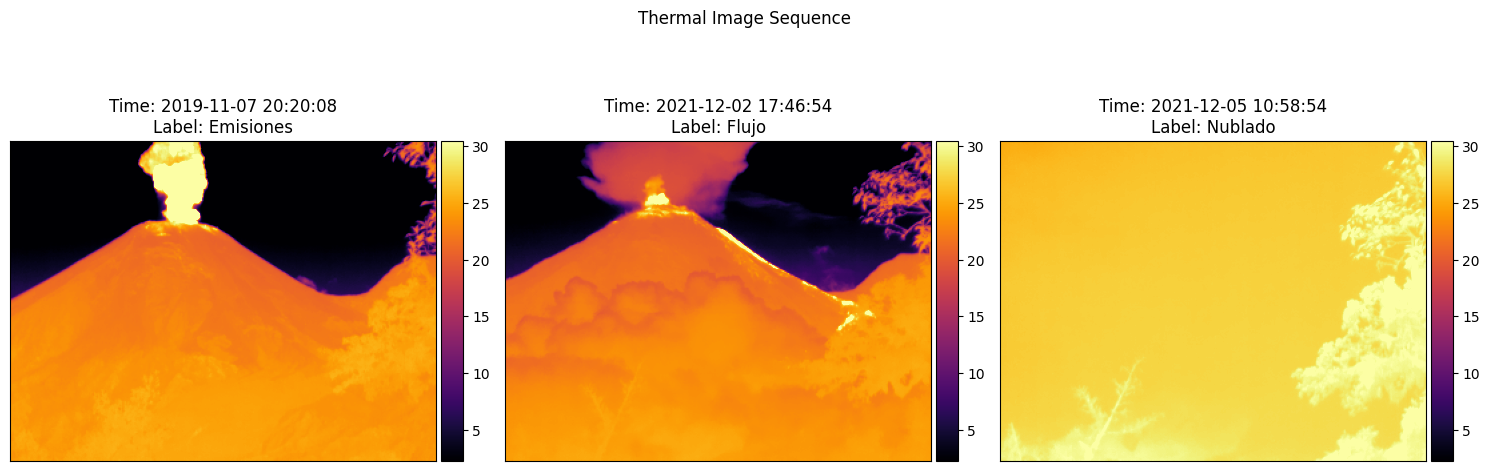

In [20]:
# Extract data for visualization
viz_data_reventador = extract_visualization_data(preprocessed_reventador)

# Use the extracted data (replaces your original lines)
timestamps = viz_data_reventador['timestamps']
numeric_labels = viz_data_reventador['numeric_labels']
label_mapping = viz_data_reventador['label_mapping']
corrected_tensor = viz_data_reventador['corrected_tensor']

label_examples = get_label_examples(numeric_labels, label_mapping)
#example_indices = list(label_examples.values())
example_indices = [490, 1240, 2250]
  
thermal_stats = get_thermal_stats(corrected_tensor)
print_thermal_stats(thermal_stats)

# Improved visualization with better contrast for Reventador
visualize_thermal_sequence(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,
    thermal_stats['global_min'],
    thermal_stats['global_max'],
    label_mapping,
    use_percentile=True,  # Use percentile normalization for better contrast
    percentile_range=(2, 98),  # Focus on the 2-98 percentile range
    cmap='inferno'
)

#### Thresholds Sequence

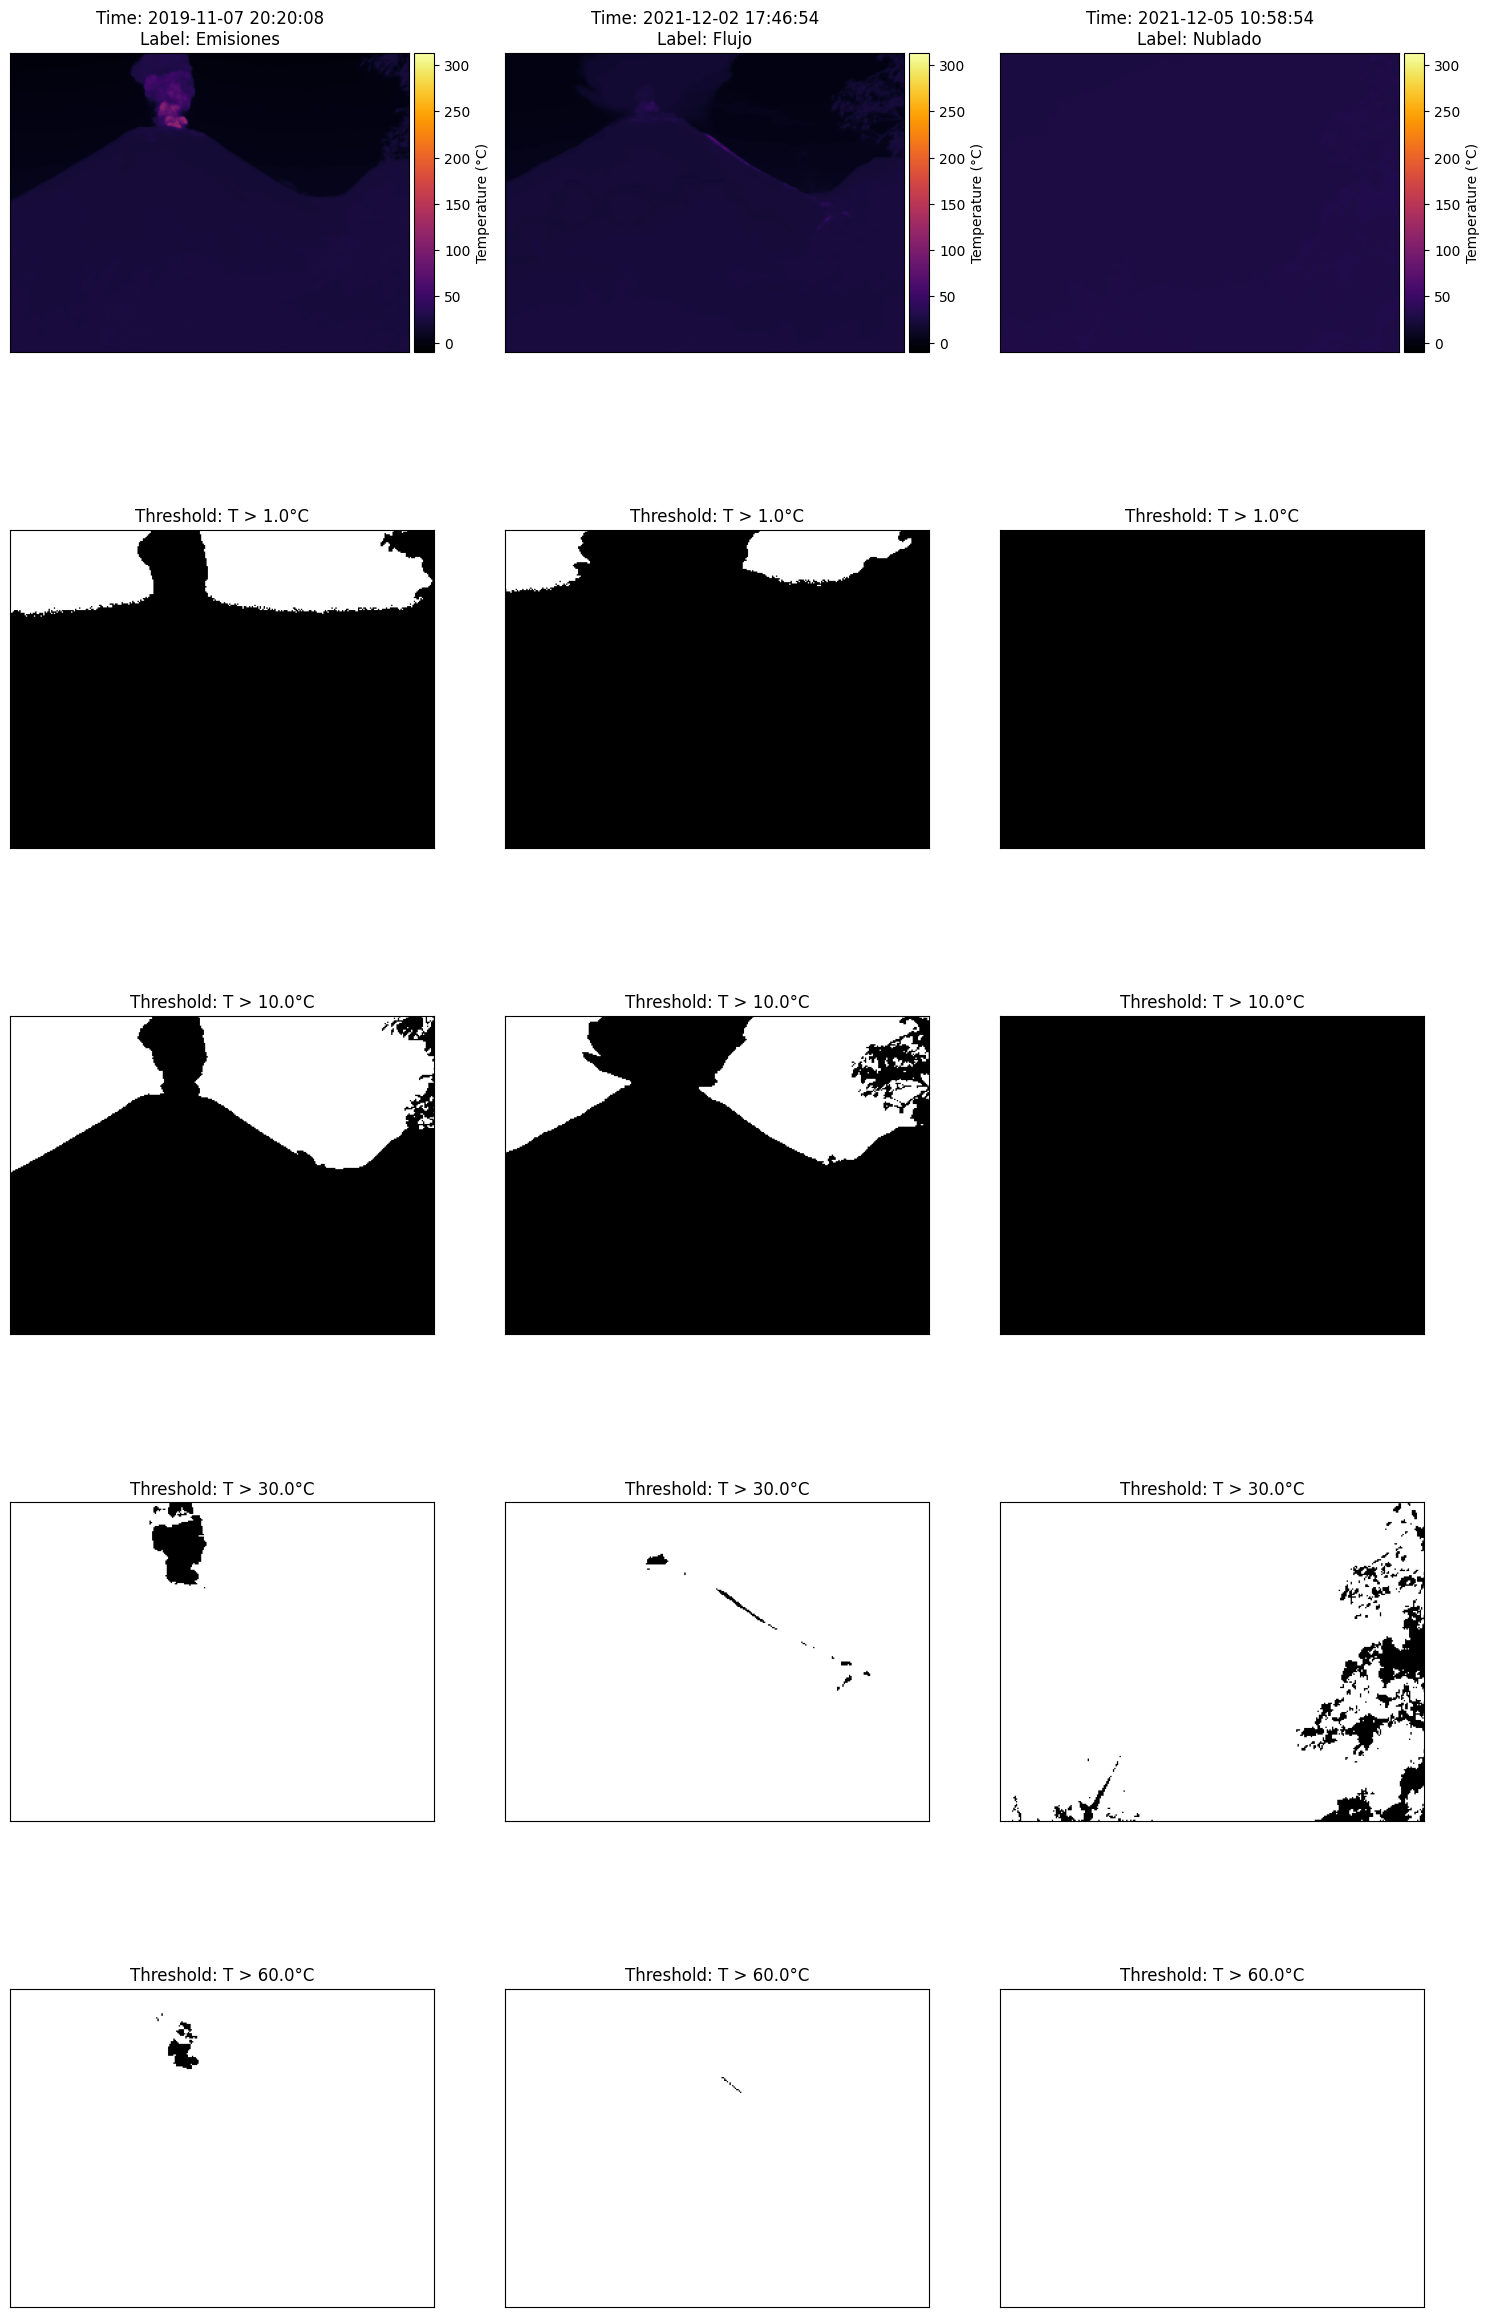

In [21]:
visualize_thermal_threshold_comparison(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,
    label_mapping,
    thresholds=reventador_thresholds
)

#### Edges Sequence


Edge Detection Statistics:
Average edge density: 13.8356
Average total edges: 14.94
Average non-zero ratio: 5.7326


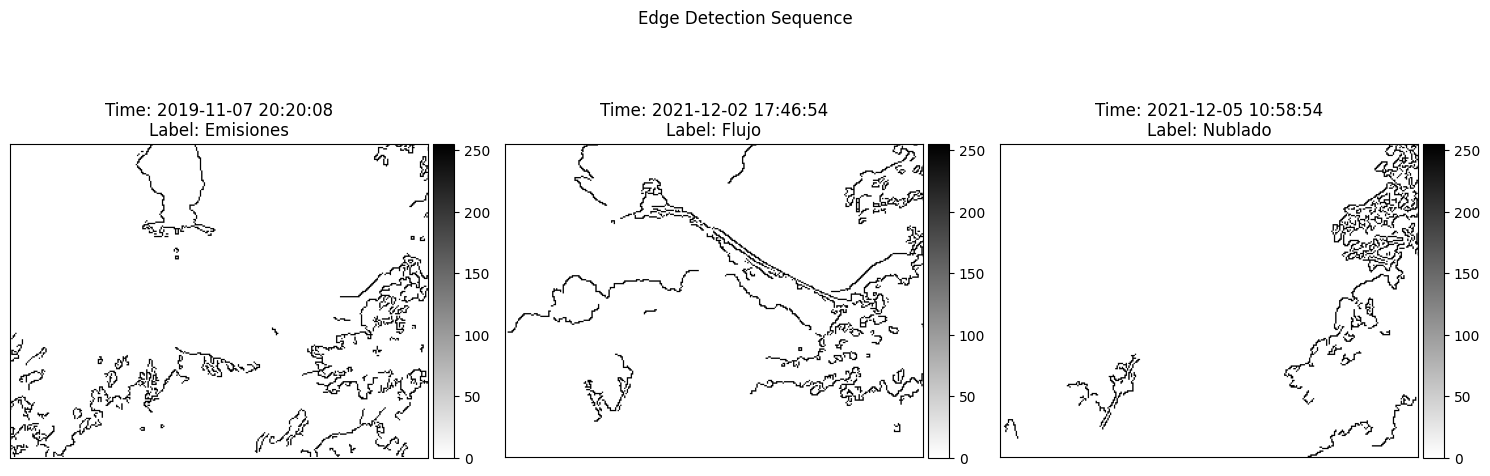

In [22]:
# Edge detection visualization and stats
edge_tensor = preprocessed_reventador['tensors']['edge']
edge_stats = get_edge_stats(edge_tensor)
print_edge_stats(edge_stats)
visualize_edge_sequence(
    edge_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices we created before
    label_mapping
)

#### Feature Composition (Academic Paper)

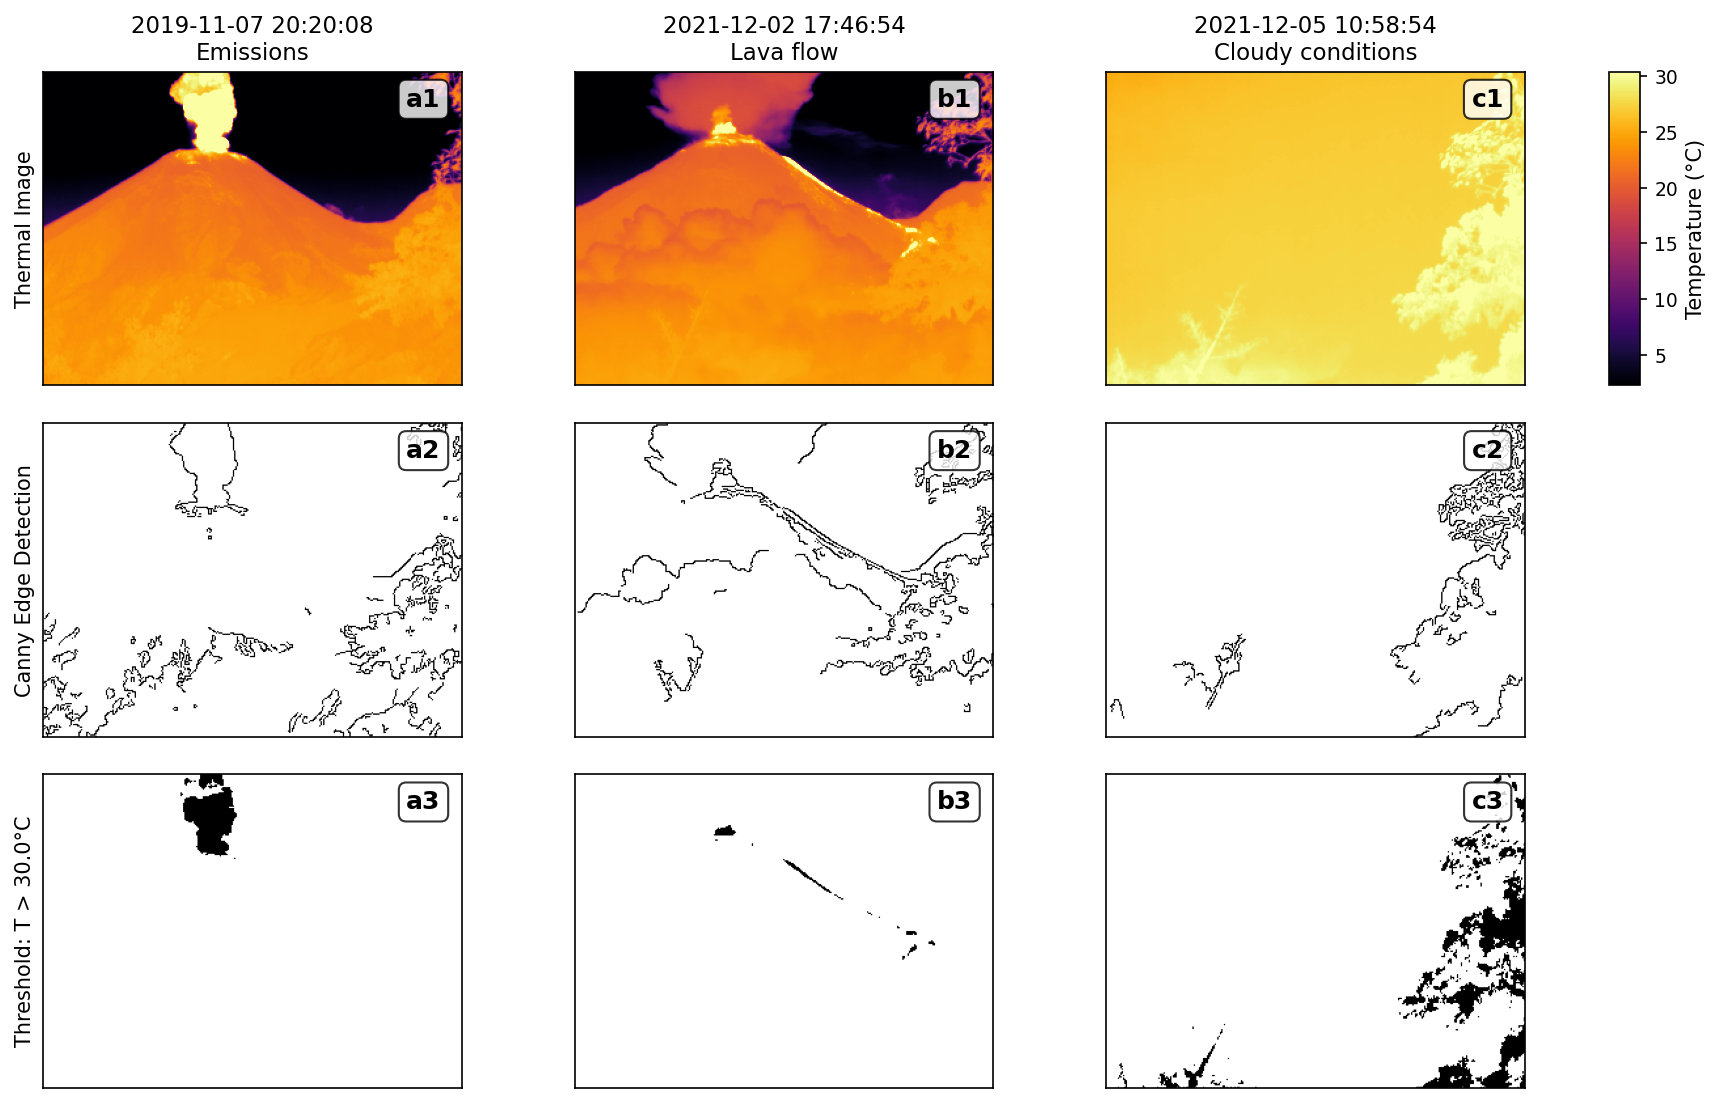

In [23]:
# Feature composition visualization for Reventador (academic paper quality)
# Using the same example indices from previous visualizations

# Get threshold tensors from preprocessed dataset
threshold_tensors_reventador = preprocessed_reventador['tensors']['threshold']

# Create English label mapping for Reventador
label_mapping_english_reventador = {
    'Lava flow': label_mapping['Flujo'],
    'Emissions': label_mapping['Emisiones'],
    'Cloudy conditions': label_mapping['Nublado']
}

# Create composition with thermal, edge detection, and threshold
# Using improved contrast with percentile normalization
fig_reventador, axes_reventador = visualize_feature_composition(
    thermal_tensor=corrected_tensor,
    edge_tensor=edge_tensor,
    threshold_tensors=threshold_tensors_reventador,
    timestamps=timestamps,
    labels=numeric_labels,
    indices=example_indices,
    label_mapping=label_mapping_english_reventador,
    threshold_name='high',
    threshold_value=reventador_thresholds['high'],
    figsize_per_col=4,
    dpi=150,
    cmap_thermal='inferno',
    show_colorbar=True,
    title_fontsize=11,
    label_fontsize=10,
    use_percentile=True,  # Enable percentile normalization
    percentile_range=(2, 98),  # Use 2-98 percentile for better contrast
    #save_path=None  # Set path to save: e.g., '../figures/reventador_composition.png'
)

In [ ]:
# Delete your tensor variables
del corrected_tensor
del edge_tensor
del preprocessed_reventador

# Run garbage collection
gc.collect()

# If using CUDA, clear the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()